#### I. Referencias consultadas

# Numerical development to resolve Time-Dependent Schrödinger equation through eigenvalue problem

## 1. Import modules with useful functions, parameters, and algorithms.

In [39]:
name_code = "03_Code_auxiliary_tests";

In [40]:
include("../modules/module_schrodinger_equation_eigenproblem.jl"); # módulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/ElectronNuclear_Coupling_Dynamics/gridap_makie`


## 2. Setting grid properties

* Tipo de grilla
* Discretización espacial
* Dominio
* Condiciones de contorno

In [41]:
Bohr_radius_meter=5.29177210903e−11;                        # [m]
Angstrom_to_meter=1e−10;                                    # [m/Å]
Angstrom_to_au=Angstrom_to_meter*(1.0/Bohr_radius_meter);   # [au/Å]
Femtoseconds_to_au=(1.0/0.0218884);                         # [au/fs]

## 5. Resolve the 2D problem

### 5.1. Resolve eigenvalue problem

In [42]:
dom_2D=(-12.0*Angstrom_to_au,12.0*Angstrom_to_au,-4.9*Angstrom_to_au,4.9*Angstrom_to_au);   # cantidad de FE y dominio espacial
n_1D_r=50;n_1D_R=50;    # cantidad de FE por dimension (cantidad de intervalos)
ΔrH=abs(dom_2D[2]-dom_2D[1])/(n_1D_r-1); ΔRH=abs(dom_2D[4]-dom_2D[3])/(n_1D_R-1)                        # tamaño del elemento 2D
partition_2D=(n_1D_r,n_1D_R);                               # grilla de tamaño n²
model_2D=CartesianDiscreteModel(dom_2D,partition_2D);   # creamos modelo con elementos cartesianos

In [43]:
writevtk(model_2D,path_models*"CartesianDiscreteModel");

In [44]:
dirichlet_values_2D=(0.0+im*0.0);        # condiciones de contorno de tipo fulldirichlet
dirichlet_tags_2D="boundary";

In [45]:
Ω_2D,dΩ_2D,Γ_2D,dΓ_2D=measures(model_2D,3,dirichlet_tags_2D);
reffe_2D=ReferenceFE(lagrangian,Float64,2);
DOF_r,DOF_R,pts=space_coord_2D(dom_2D,ΔrH,ΔRH);

In [46]:
VHre_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_2D);
UHre_2D=TrialFESpace(VHre_2D,dirichlet_values_2D);

R₁=-5.0*Angstrom_to_au;R₂=5.0*Angstrom_to_au;Rc=1.5*Angstrom_to_au;Rf=1.5*Angstrom_to_au; # parameters

pH_2D,qH_2D,rH_2D=eigenvalue_problem_functions((R₁,R₂,Rc,Rf);switch_potential = "Electron_Nuclear_Potential_2D")
aH_2D,bH_2D=bilineal_forms(pH_2D,qH_2D,rH_2D,dΩ_2D);

Set Electron-Nuclear potential


In [47]:
nevH=10;
probH_2D=EigenProblem(aH_2D,bH_2D,UHre_2D,VHre_2D;nev=nevH,tol=10^(-9),maxiter=300,explicittransform=:none,sigma=-10.0);

In [48]:
ϵH_2D,ϕH_2D=solve(probH_2D);

In [49]:
# Escribimos autovectores para visualizar externamente
write_data=true;
if write_data
    for i in 1:nevH
        writevtk(Ω_2D,path_images*"eigenprob_2D_01_num$(i)",cellfields=["phi_real" => real(ϕH_2D[i]), "phi_imag" => imag(ϕH_2D[i])]);
    end
end

In [50]:
S_2D=TimeIndependet_Diff_Shannon_Entropy(ϕH_2D,UHre_2D,dΩ_2D)

10-element Vector{Float64}:
 5.229507640055746
 5.071584069225998
 5.0339571297502825
 5.277693934753637
 5.3059573769403325
 5.3611455396676275
 5.294337034940924
 5.4626976324826435
 5.4707587139072205
 5.456469577339283

### 5.2. Resolve time-dependent Schrödinger equation

#### 5.2.1. Create initial condition

In [51]:
function gaussian_factor(x,R₀,β,component)
    return exp(-β*pow((x[component]-R₀),2));
end

function create_initial_state_2D(ϕₙ,n,Ω,dΩ,R₀,β;component=2)
    𝛹ₓ₀ = CellField(x->gaussian_factor(x,R₀,β,component),Ω)*ϕₙ[n];
    𝛹ₓ₀=𝛹ₓ₀*(1.0/norm_L2(𝛹ₓ₀,dΩ));
    return 𝛹ₓ₀;
end

create_initial_state_2D (generic function with 1 method)

In [52]:
function create_initial_state_2D_v2(ϕₙ,n,TrialSpace,Ω,dΩ,R₀,β;component=2)
    χ₁=interpolate_everywhere(ϕₙ[n],TrialSpace);
    χ₂=interpolate_everywhere(CellField(x->gaussian_factor(x,R₀,β,component),Ω),TrialSpace);
    𝛹ₓ₀=interpolate_everywhere(χ₁*χ₂,TrialSpace);
    𝛹ₓ₀=𝛹ₓ₀*(1.0/norm_L2(𝛹ₓ₀,dΩ));
    return 𝛹ₓ₀;
end

create_initial_state_2D_v2 (generic function with 1 method)

In [53]:
# 𝛹ₓ₀=create_initial_state_2D_v2(ϕH_2D,2,UHre_2D,Ω_2D,dΩ_2D,-1.5*Angstrom_to_au,3.57*(1.0/(Angstrom_to_au*Angstrom_to_au)));
𝛹ₓ₀=create_initial_state_2D(ϕH_2D,2,Ω_2D,dΩ_2D,-1.5*Angstrom_to_au,3.57*(1.0/(Angstrom_to_au*Angstrom_to_au)));

In [54]:
writevtk(Ω_2D,path_images*"initial_condition",cellfields=["real(𝛹ₓ₀)" =>real(𝛹ₓ₀),"imag(𝛹ₓ₀)" =>imag(𝛹ₓ₀)]);

#### 5.2.2. Time evolution

In [55]:
t_start=0.0;t_end=100*Femtoseconds_to_au;    # tiempos adimensionales inicial y final
num_steps=round(Int,abs(t_end-t_start)+1);   # number of dicrete time points  
n_int_save=round(Int,(num_steps-1)/20);      # Intervals where data is saved n_int_save=n_inf/numero=(num_steps-1)/numero
Δt=abs(t_end-t_start)*(1.0/(num_steps-1));   # time step

n_int_save2=round(Int,n_int_save/10);

time_vec=[t_start+Δt*(i-1) for i in 1:n_int_save2:num_steps];

In [56]:
𝛹ₓₜ=evolution_schrodinger(𝛹ₓ₀,ϕH_2D,ϵH_2D,UHre_2D,dΩ_2D,time_vec);

In [57]:
for i in 1:10:length(𝛹ₓₜ)
    writevtk(Ω_2D,path_images*"evolution_wave_function_$(lpad(i,3,'0'))",cellfields=["real(𝛹ₓₜ)" =>real(𝛹ₓₜ[i]),"imag(𝛹ₓₜ)" =>imag(𝛹ₓₜ[i])]);
end

### 5.3. Calculate entropy

In [58]:
function Partial_probability_density(𝛹ₓ_vector,x₁_vector,x₂_vector,TrialSpace,Ω,dΩ)
    dim𝛹ₓ=length(𝛹ₓ_vector);dimx₁=length(x₁_vector);dimx₂=length(x₂_vector);
    ρ_x₁_matrix=zeros(Float64,dimx₁,dim𝛹ₓ);
    ρ_x₂_matrix=zeros(Float64,dimx₂,dim𝛹ₓ);

    for t_index in 1:dim𝛹ₓ
        𝛹ₓᵢ=interpolate_everywhere(𝛹ₓ_vector[t_index],TrialSpace);
        𝛹ₓᵢ=𝛹ₓᵢ/norm_L2(𝛹ₓᵢ,dΩ);
        ρₓᵢ=real(𝛹ₓᵢ'*𝛹ₓᵢ);

        for x₁_index in 1:dimx₁
            δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,x₁_vector[x₁_index],1.0,1),Ω);
            δnorm=sum(integrate(δKroneckerGridap,dΩ));
            δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,x₁_vector[x₁_index],δnorm,1),Ω);
            ρ_x₁_matrix[x₁_index,t_index]=sum(integrate(ρₓᵢ*δKroneckerGridap,dΩ))
        end

        for x₂_index in 1:dimx₂
            δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,x₂_vector[x₂_index],1.0,2),Ω);
            δnorm=sum(integrate(δKroneckerGridap,dΩ));
            δKroneckerGridap=CellField(x->kronecker_deltax_Gridap_v2(x,x₂_vector[x₂_index],δnorm,2),Ω);
            ρ_x₂_matrix[x₂_index,t_index]=sum(integrate(ρₓᵢ*δKroneckerGridap,dΩ))
        end
    end
    return ρ_x₁_matrix,ρ_x₂_matrix;
end

Partial_probability_density (generic function with 1 method)

In [59]:
electronic_ρ_matrix,nuclear_ρ_matrix=Partial_probability_density(𝛹ₓₜ,DOF_r,DOF_R,UHre_2D,Ω_2D,dΩ_2D);

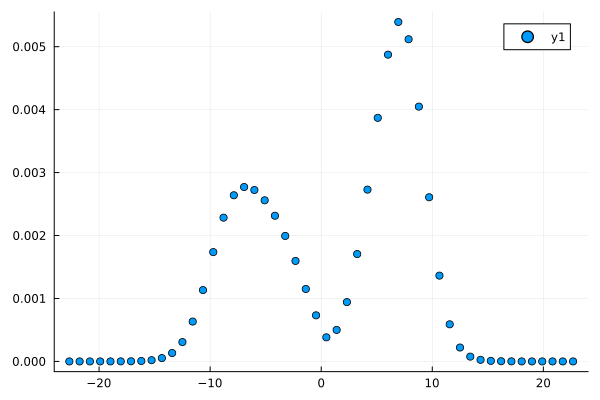

In [60]:
scatter(DOF_r,electronic_ρ_matrix[:,end])

In [61]:
# δKroneckerGridap = CellField(x->kronecker_deltax_Gridap_v2(x,DOF_r[1],1.0),Ω_2D);
# δnorm=sum(integrate(δKroneckerGridap,dΩ_2D));
# δKroneckerGridap = CellField(x->kronecker_deltax_Gridap_v2(x,DOF_r[1],δnorm),Ω_2D);

# writevtk(Ω_2D,path_images*"aux_function",cellfields=["δKroneckerGridap" =>δKroneckerGridap]);

In [62]:
function Trapezoidal_Integration_Method(x_vec,fx_vec)
    dim_x=length(x_vec);

    coef_vec=copy(x_vec);
    coef_vec[1]=1.0;
    coef_vec[2:(dim_x-1)].=2.0;
    coef_vec[end]=1.0;

    function_vec=copy(x_vec);
    function_vec[1]=fx_vec[1];
    function_vec[2:(dim_x-1)].=fx_vec[2:(length(x_vec)-1)];
    function_vec[end]=fx_vec[end];

    Δx=abs(x_vec[2]-x_vec[1]); # válido para cuando Δx es constante

    return 0.5*Δx*(transpose(function_vec)*coef_vec);
end

function Simpson_Integration_Method(x_vec,fx_vec)
    dim_x=length(x_vec);

    coef_vec=copy(x_vec);
    coef_vec[1]=1.0;
    coef_vec[end]=1.0;

    function_vec=copy(x_vec);
    function_vec[1]=fx_vec[1];
    function_vec[2:(dim_x-1)].=fx_vec[2:(length(x_vec)-1)];
    function_vec[end]=fx_vec[end];

    Δx=abs(x_vec[2]-x_vec[1]); # válido para cuando Δx es constante

    # cantidad de puntos es par => Simpson 1/3
    if (mod(dim_x,2)==0)
        for i in 2:(length(x_vec)-1);
            if (mod(i,2)==0)    # ìndice múltiplo de 2
                coef_vec[i]=4.0;
            else
                coef_vec[i]=2.0;
            end
        end
        return (1.0/3.0)*Δx*(transpose(function_vec)*coef_vec);
    # cantidad de puntos es par => Simpson 3/8
    else
        for i in 2:(length(x_vec)-1);
            if (mod(i,3)==0)    # ìndice múltiplo de 3
                coef_vec[i]=2.0;
            else
                coef_vec[i]=3.0;
            end
        end
        return (3.0/8.0)*Δx*(transpose(function_vec)*coef_vec);
    end
end

Simpson_Integration_Method (generic function with 1 method)

In [63]:
function integration_argument_diff_shannon_entropy(ρ_x_vector)
    return -ρ_x_vector.*log.(ρ_x_vector)
end

function Reduced_TimeIndependet_Diff_Shannon_Entropy(x_vec,ρ_x_vector;IntType="trapezoidal")
    if (IntType=="trapezoidal")
        return Trapezoidal_Integration_Method(x_vec,integration_argument_diff_shannon_entropy(ρ_x_vector))
    elseif (IntType=="simpson")
        return Simpson_Integration_Method(x_vec,integration_argument_diff_shannon_entropy(ρ_x_vector))
    end
end

function Reduced_TimeDependent_Diff_Shannon_Entropy(x_vec,ρ_x_matrix;IntType="trapezoidal")
    Sx_vector=Vector{Float64}(undef,length(ρ_x_matrix[1,:]));
    for i in 1:length(Sx_vector)
        Sx_vector[i]=Reduced_TimeIndependet_Diff_Shannon_Entropy(x_vec,ρ_x_matrix[:,i];IntType=IntType)
    end
    return Sx_vector;
end

Reduced_TimeDependent_Diff_Shannon_Entropy (generic function with 1 method)

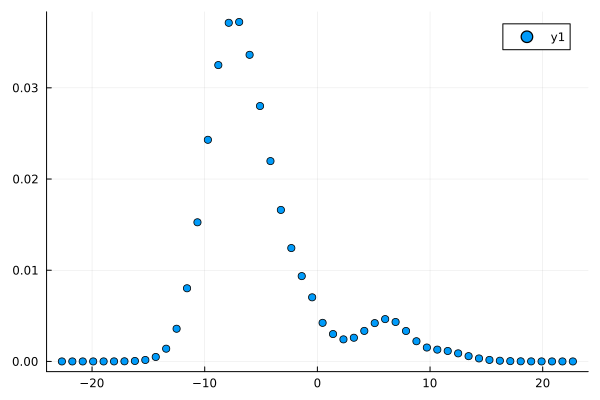

In [64]:
scatter(DOF_r,integration_argument_diff_shannon_entropy(electronic_ρ_matrix[:,2]))

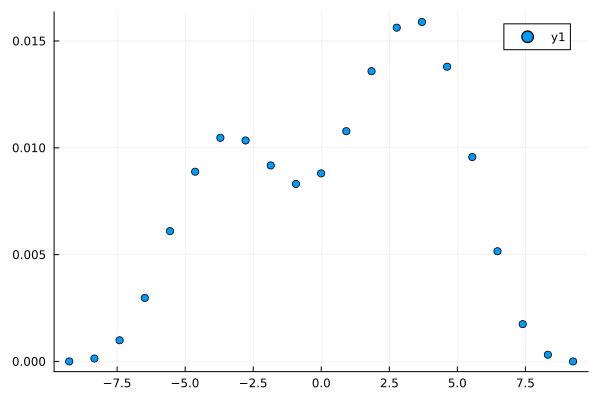

In [65]:
scatter(DOF_R,integration_argument_diff_shannon_entropy(nuclear_ρ_matrix[:,end]))

In [66]:
total_S_2D=TimeIndependet_Diff_Shannon_Entropy(𝛹ₓₜ,UHre_2D,dΩ_2D);
electronic_S=Reduced_TimeDependent_Diff_Shannon_Entropy(DOF_r,electronic_ρ_matrix)
nuclear_S=Reduced_TimeDependent_Diff_Shannon_Entropy(DOF_R,nuclear_ρ_matrix)
mutual_info=electronic_S.+nuclear_S.-total_S_2D;

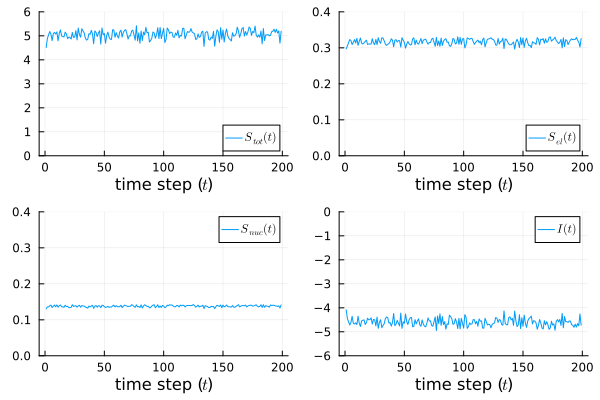

In [67]:
plot1=plot();
plot2=plot!(plot1,total_S_2D,label="\$S_{tot}(t)\$");
plot2=plot!(xlabel="time step (\$t\$)",ylim=(0,6))

plot3=plot();
plot4=plot!(plot3,electronic_S,label="\$S_{el}(t)\$");
plot4=plot!(xlabel="time step (\$t\$)",ylim=(0,0.4))

plot5=plot();
plot6=plot!(plot5,nuclear_S,label="\$S_{nuc}(t)\$");
plot6=plot!(xlabel="time step (\$t\$)",ylim=(0,0.4))

plot7=plot();
plot8=plot!(plot7,mutual_info,label="\$I(t)\$");
plot8=plot!(xlabel="time step (\$t\$)",ylim=(-6,0))

plot3=plot(plot2,plot4,plot6,plot8,layout=(2,2));
display(plot3)

In [68]:
electronic_S=Reduced_TimeDependent_Diff_Shannon_Entropy(DOF_r,electronic_ρ_matrix;IntType="simpson")
nuclear_S=Reduced_TimeDependent_Diff_Shannon_Entropy(DOF_R,nuclear_ρ_matrix;IntType="simpson")
mutual_info=electronic_S.+nuclear_S.-total_S_2D;

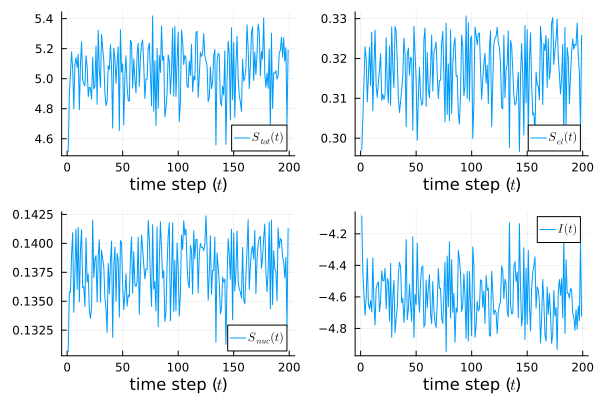

In [69]:
plot1=plot();
plot2=plot!(plot1,total_S_2D,label="\$S_{tot}(t)\$");
plot2=plot!(xlabel="time step (\$t\$)")

plot3=plot();
plot4=plot!(plot3,electronic_S,label="\$S_{el}(t)\$");
plot4=plot!(xlabel="time step (\$t\$)")

plot5=plot();
plot6=plot!(plot5,nuclear_S,label="\$S_{nuc}(t)\$");
plot6=plot!(xlabel="time step (\$t\$)")

plot7=plot();
plot8=plot!(plot7,mutual_info,label="\$I(t)\$");
plot8=plot!(xlabel="time step (\$t\$)")

plot3=plot(plot2,plot4,plot6,plot8,layout=(2,2));
display(plot3)